# Title: Predictive Analytics for Electronics Store Sales Using Big Data Techniques

**Objectives**:

*   Analyze historical sales data to identify trends and patterns in customer purchasing behavior.
*   Create a predictive model to project sales in the future for various product categories.
*   Determine the main variables affecting sales performance for different product lines.
*   Build a recommendation engine that makes product recommendations based on past purchases made by customers.


**Integration Approach**:
Our Project will follow this Workflow:
*   Data Ingestion: Load the eCommerce dataset into HDFS.
*   Data Preprocessing: Use Spark to clean and transform the data, handling missing values and outliers.
*   Exploratory Data Analysis: Utilize Hive and Spark SQL for initial data exploration and aggregation.
*   Feature Engineering: Create relevant features for our machine learning models using Spark.
*   Model Training: Implement and train our machine learning models using Spark MLlib.
*   Model Evaluation: Assess model performance and fine-tune as necessary.
*   Deployment: Develop a system to make real-time predictions and recommendations.

**Dataset**: https://www.kaggle.com/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/data


# Install PySpark

In [ ]:
!pip install pyspark findspark

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import kagglehub
import seaborn as sns

In [ ]:
import findspark
findspark.init()

### Start a session

In [ ]:
spark = SparkSession.builder.appName("eCommerceProject").getOrCreate()

# Load Dataset

In [ ]:
# Download latest version
data = kagglehub.dataset_download("mkechinov/ecommerce-purchase-history-from-electronics-store")

print("Path to dataset files:", data)

100%|██████████| 50.5M/50.5M [00:03<00:00, 14.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/versions/2


In [ ]:
data = spark.read.csv("/root/.cache/kagglehub/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/versions/2", header=True, inferSchema=True)
data

DataFrame[event_time: timestamp, order_id: bigint, product_id: bigint, category_id: bigint, category_code: string, brand: string, price: double, user_id: bigint]

### Data types

In [ ]:
data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: long (nullable = true)



In [ ]:
for column in data.columns:
    non_null_count = data.filter(data[column].isNotNull()).count()
    print(f"Column: {column}, Type: {data.schema[column].dataType}, Non-Null Count: {non_null_count}")


Column: event_time, Type: TimestampType(), Non-Null Count: 2633521
Column: order_id, Type: LongType(), Non-Null Count: 2633521
Column: product_id, Type: LongType(), Non-Null Count: 2633521
Column: category_id, Type: LongType(), Non-Null Count: 2201567
Column: category_code, Type: StringType(), Non-Null Count: 2021319
Column: brand, Type: StringType(), Non-Null Count: 2127516
Column: price, Type: DoubleType(), Non-Null Count: 2201567
Column: user_id, Type: LongType(), Non-Null Count: 564169


# Data Preprocessing

In [ ]:
# Show the total row count and display a sample with null values if any
print("Before removing null values:")
print("Total rows:", data.count())
data.show(10)

Before removing null values:
Total rows: 2633521
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|         event_time|           order_id|         product_id|        category_id|       category_code|  brand|  price|            user_id|
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|1515915625447879434|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52

In [ ]:
# Remove rows with null values
data_cleaned = data.dropna()

# Show the total row count after removing null values
print("\nAfter removing null values:")
print("Total rows:", data_cleaned.count())
data_cleaned.show(10)



After removing null values:
Total rows: 420718
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|         event_time|           order_id|         product_id|        category_id|       category_code|  brand|  price|            user_id|
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|1515915625447879434|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|

In [ ]:
data_cleaned.createOrReplaceTempView("ecommerce_data")

# Data Analysis

### Weekly Analysis

In [ ]:
# Find the best sales day of the week
result = spark.sql("""
  SELECT
    DAYOFWEEK(event_time) AS day_of_week,
    COUNT(*) AS purchase_count
  FROM
    ecommerce_data
  GROUP BY
    day_of_week
  ORDER BY
    purchase_count DESC
""")

# Display the result
result.show()


+-----------+--------------+
|day_of_week|purchase_count|
+-----------+--------------+
|          7|         67058|
|          1|         62631|
|          4|         59809|
|          3|         59230|
|          5|         58709|
|          2|         57541|
|          6|         55740|
+-----------+--------------+



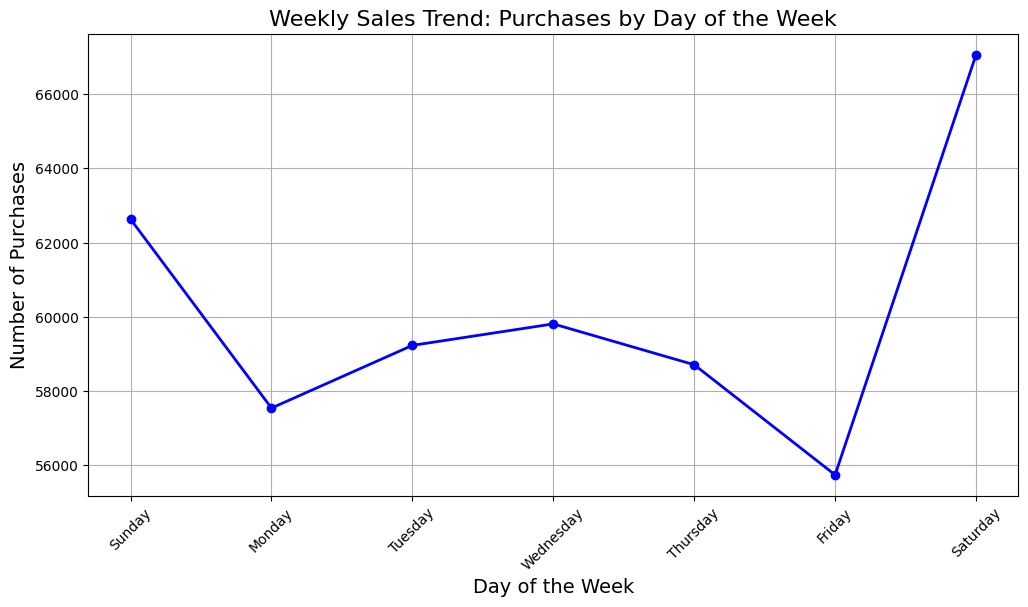

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_weekly = result.toPandas()

# Map day_of_week integer to actual day names
days_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df_weekly['day_of_week'] = df_weekly['day_of_week'].map(days_map)

# Sort data by day of the week order
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_weekly['day_of_week'] = pd.Categorical(df_weekly['day_of_week'], categories=ordered_days, ordered=True)
df_weekly = df_weekly.sort_values(by='day_of_week')

# Plotting the line chart
plt.figure(figsize=(12, 6))
plt.plot(df_weekly['day_of_week'], df_weekly['purchase_count'], marker='o', color='b', linestyle='-', linewidth=2)
plt.title("Weekly Sales Trend: Purchases by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("Number of Purchases", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Peak Shopping Times

In [ ]:
result = spark.sql("""
  SELECT HOUR(event_time) as hour, COUNT(*) as purchase_count
  FROM ecommerce_data
  GROUP BY hour
  ORDER BY purchase_count DESC
""")

result.show(10)

+----+--------------+
|hour|purchase_count|
+----+--------------+
|   9|         38991|
|  10|         38774|
|   8|         37669|
|   7|         36704|
|  11|         35490|
|   6|         34852|
|  12|         30928|
|   5|         29983|
|  13|         24980|
|   4|         20076|
+----+--------------+
only showing top 10 rows



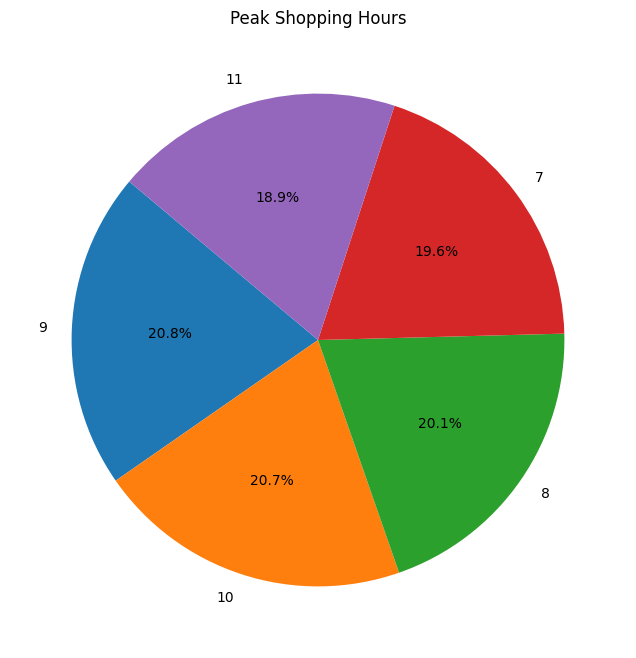

In [ ]:
# Convert Spark DataFrame to Pandas for easier visualization
result_df = result.limit(5).toPandas()  # Select top 10 peak hours

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result_df['purchase_count'], labels=result_df['hour'], autopct='%1.1f%%', startangle=140)
plt.title("Peak Shopping Hours")
plt.show()


## Top Selling Products

In [ ]:
result = spark.sql("""
  SELECT brand, product_id, COUNT(*) as purchase_count
  FROM ecommerce_data
  GROUP BY product_id, brand
  ORDER BY purchase_count DESC
  LIMIT 30
""")

result.show()


+-------+-------------------+--------------+
|  brand|         product_id|purchase_count|
+-------+-------------------+--------------+
|samsung|1515966223517846928|          2759|
|samsung|1515966223509106786|          2600|
|  apple|1515966223509088613|          2556|
|samsung|1515966223509088532|          2550|
|  apple|1515966223509088567|          2497|
|samsung|1515966223510174551|          2370|
|samsung|1515966223509088521|          2156|
|samsung|1515966223509104145|          2037|
|samsung|1515966223509088639|          1904|
|    ava|1515966223509088620|          1723|
|  apple|1515966223509088671|          1664|
|    ava|1515966223509089642|          1558|
|samsung|2273948227654910595|          1441|
|samsung|1515966223509089514|          1354|
|samsung|1515966223509089067|          1274|
|samsung|1515966223509088692|          1220|
|    ava|1515966223521756078|          1191|
|samsung|1515966223522710798|          1180|
|  apple|1515966223509553808|          1179|
|samsung|1

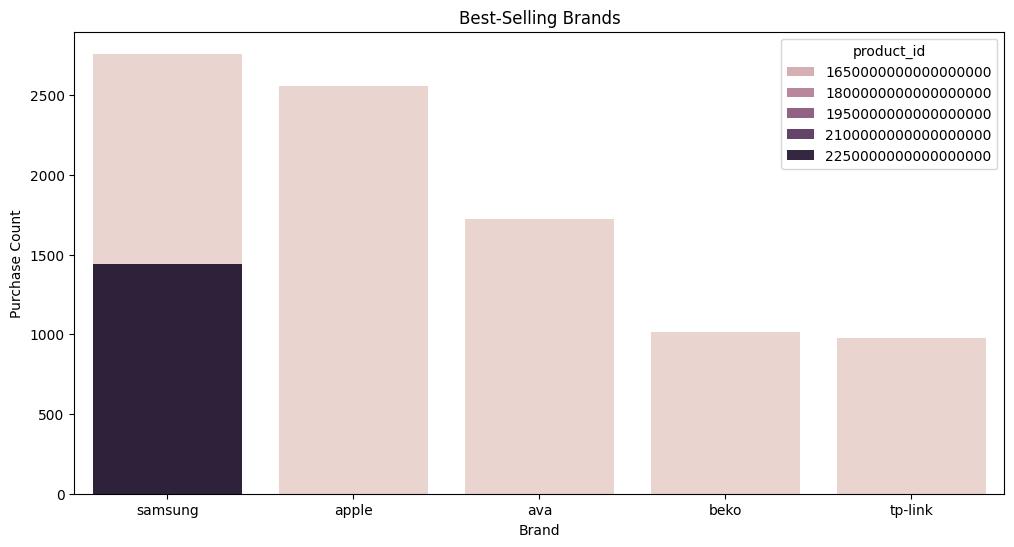

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
top_products_df = result.toPandas()

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="brand", y="purchase_count", data=top_products_df, hue="product_id", dodge=False)

# Customize the plot
plt.title("Best-Selling Brands")
plt.xlabel("Brand")
plt.ylabel("Purchase Count")

plt.show()

## Average Spending by Brand

In [ ]:
result = spark.sql("""
  SELECT brand, AVG(price) as avg_spending
  FROM ecommerce_data
  GROUP BY brand
  ORDER BY avg_spending DESC
  LIMIT 10
""")

result.show()

+----------+------------------+
|     brand|      avg_spending|
+----------+------------------+
| yamaguchi|           6215.25|
| technogym| 3674.898333333333|
|      gewa|           3261.78|
|     loewe|2321.5024999999996|
|    nvidia|           2218.65|
|   hitachi|2165.3228571428567|
|  liebherr|2105.7957142857144|
|      kona|1836.2166666666667|
|    casada|1546.7737837837842|
|waterrower|           1377.29|
+----------+------------------+



<ipython-input-19-af7cc55dbaf3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_spending", y="brand", data=avg_spending_df, palette="viridis")


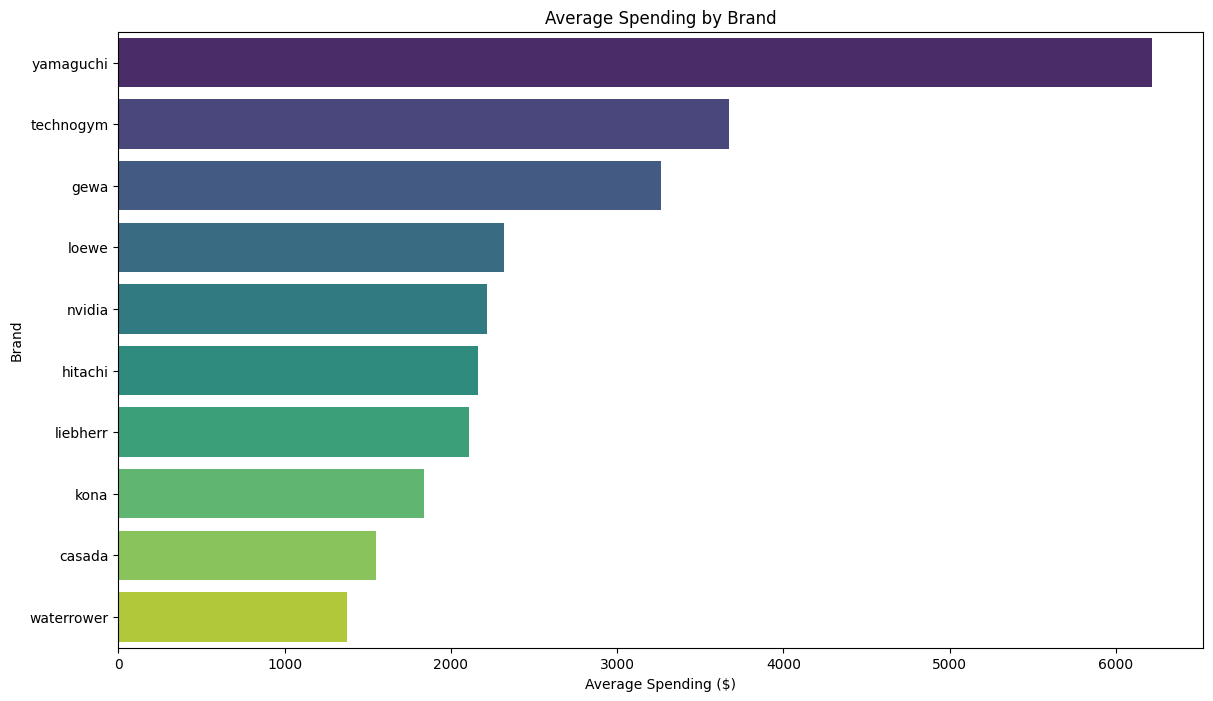

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for plotting
avg_spending_df = result.toPandas()

# Plot the average spending by brand
plt.figure(figsize=(14, 8))
sns.barplot(x="avg_spending", y="brand", data=avg_spending_df, palette="viridis")

# Customize the plot
plt.title("Average Spending by Brand")
plt.xlabel("Average Spending ($)")
plt.ylabel("Brand")

plt.show()

## Product Popularity by Category

In [ ]:
result = spark.sql("""
  SELECT category_code, COUNT(*) as category_popularity
  FROM ecommerce_data
  GROUP BY category_code
  ORDER BY category_popularity DESC
  LIMIT 10
""")

result.show()

+--------------------+-------------------+
|       category_code|category_popularity|
+--------------------+-------------------+
|electronics.smart...|             102312|
|  computers.notebook|              25883|
|appliances.kitche...|              20047|
|electronics.audio...|              19805|
|electronics.video.tv|              17662|
|appliances.enviro...|              15942|
|appliances.kitche...|              14187|
|appliances.kitche...|              11909|
|computers.periphe...|              10166|
|furniture.kitchen...|               9700|
+--------------------+-------------------+



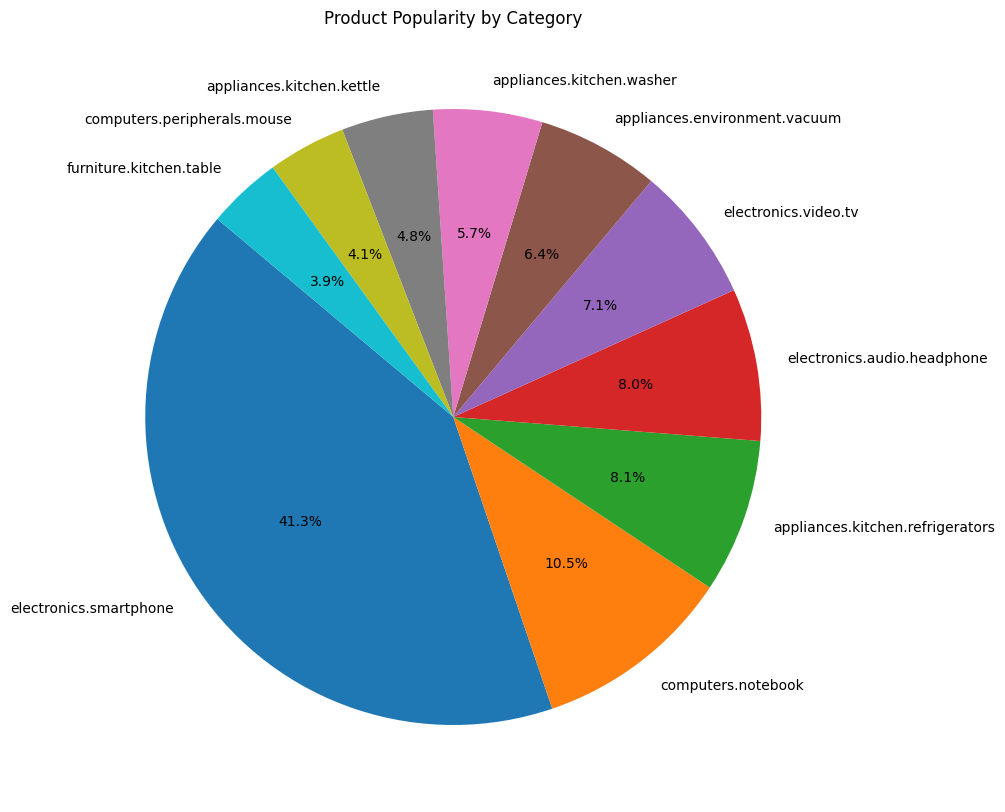

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
category_popularity_df = result.toPandas()

# Plot a pie chart
plt.figure(figsize=(10, 10))
plt.pie(category_popularity_df['category_popularity'], labels=category_popularity_df['category_code'], autopct='%1.1f%%', startangle=140)
plt.title("Product Popularity by Category")
plt.show()


## Monthly Revenue Trends

In [ ]:
result = spark.sql("""
  SELECT YEAR(event_time) as year, MONTH(event_time) as month, SUM(price) as monthly_revenue
  FROM ecommerce_data
  WHERE YEAR(event_time) = 2020
  GROUP BY year, month
  ORDER BY month
""")

result.show()


+----+-----+--------------------+
|year|month|     monthly_revenue|
+----+-----+--------------------+
|2020|    1|  1512733.1499999936|
|2020|    2|  1928107.4199999848|
|2020|    3|    2532486.75999996|
|2020|    4|   1550330.440000003|
|2020|    5|   7180919.010000027|
|2020|    6|   6834606.499999966|
|2020|    7|1.5112834930001142E7|
|2020|    8| 2.601872414000149E7|
|2020|    9|1.5713247590000922E7|
|2020|   10| 1.763243188000201E7|
|2020|   11|1.0753887050000735E7|
+----+-----+--------------------+



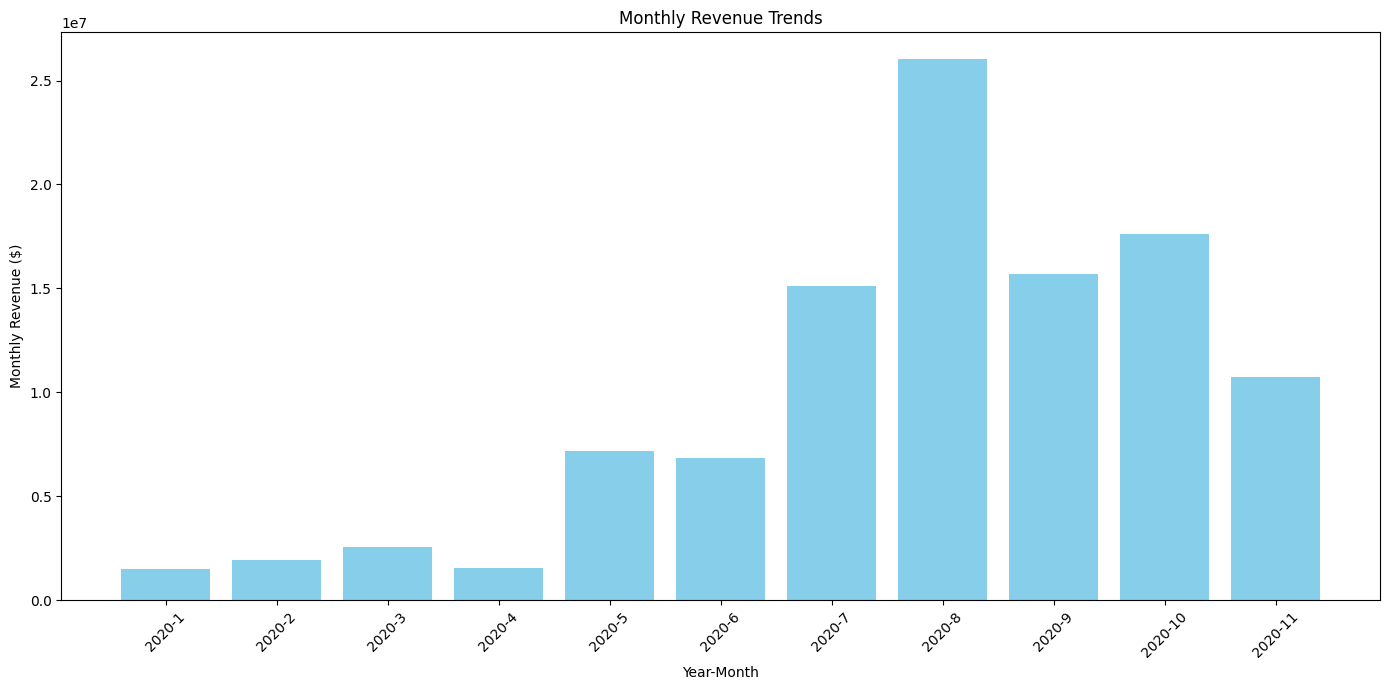

In [ ]:
# Convert Spark DataFrame to Pandas for plotting
monthly_revenue_df = result.toPandas()

# Combine the year and month columns into a single 'year_month' column
monthly_revenue_df['year_month'] = monthly_revenue_df['year'].astype(str) + '-' + monthly_revenue_df['month'].astype(str)

# Plot the column chart for monthly revenue
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.bar(monthly_revenue_df['year_month'], monthly_revenue_df['monthly_revenue'], color='skyblue')
plt.xlabel("Year-Month")
plt.ylabel("Monthly Revenue ($)")
plt.title("Monthly Revenue Trends")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Order VS Sales for the Last 6 Months

In [ ]:
# To be continued.